# PROGETTO LABORATORIO DI BIG DATA DATA MINING E DATA ANALYTICS
PROGETTO DI CLASSIFICAZIONE: PREDIZIONE DELLA POPOLARITÀ SPOTIFY

**Dati presi in analisi:**
Ho scelto di analizzare le statistiche di ascolto di Spotify dal 2009 al 2025.
Questi dati sono stati ottenuti tramite il sito Kaggle che raccoglie dati di varie fonti.

Obiettivo: Costruire un modello di classificazione in grado di prevedere se un brano supererà una soglia di successo (Alta Popolarità) basandosi sulle sue caratteristiche audio.

1. **Setup e caricamento dati:**
    In questa fase iniziale vengono importate le librerie fondamentali per l'analisi dei dati (Pandas e Numpy) e la visualizazione (Matplotlib e Seaborn) e il Machine Learning (Scikit-learn e tensorflow). Il dataset viene caricato e visualizzato e vengono verficati i tipi di dati e i valori mancanti.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf # 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense       

# Caricamento del dataset
file_path = r'/Users/chiaracasali/Desktop/laboratorio di big data, data mining e data analytics/progetto_big_data/archive/spotify_data clean.csv' 
df = pd.read_csv(file_path, encoding='utf-8', sep=',')

print(df.head())
df.info()

                 track_id                                       track_name  \
0  3EJS5LyekDim1Tf5rBFmZl                    Trippy Mane (ft. Project Pat)   
1  1oQW6G2ZiwMuHqlPpP27DB                                             OMG!   
2  7mdkjzoIYlf1rx9EtBpGmU                                      Hard 2 Find   
3  67rW0Zl7oB3qEpD5YWWE5w  Still Get Like That (ft. Project Pat & Starrah)   
4  15xptTfRBrjsppW0INUZjf                            ride me like a harley   

   track_number  track_popularity  explicit artist_name  artist_popularity  \
0             4                 0      True       Diplo                 77   
1             1                 0      True    Yelawolf                 64   
2             1                 4      True   Riff Raff                 48   
3             8                30      True       Diplo                 77   
4             2                 0      True     Rumelis                 48   

   artist_followers                      artist_genres  \
0   

2. **Data cleaning e preparazione modello:** preparazione dei dati per l'analisi (Pandas).
In questo passaggio vengono filtrate le colonne non utili per l'analisi.
Viene creata la variabile target high_popularity, trasformando la colonna popularity in una variabile binaria.
Viene applicato lo split dei dati in training e test.
Uso della mediana come soglia per dividere le canzoni in due categorie (altra popolarità, bassa popolarità).


2.1 **Creazione della variabile target:** Poiché la popularity è continua, dobbiamo trasformarla in una variabile categoriale (classificazione binaria). Useremo la mediana come soglia per dividere le canzoni in due classi:

In [3]:
# Calcolo della mediana della popolarità dalla colonna originale
median_popularity = df['track_popularity'].median()

# Creazione della nuova variabile target: 1 se Alta Popolarità, 0 se Bassa Popolarità
df['high_popularity'] = (df['track_popularity'] >= median_popularity).astype(int)

print(f"Mediana Popolarità: {median_popularity:.2f}")
print("Distribuzione della nuova variabile target:")
# Normalizzazione per mostrare le percentuali
print(df['high_popularity'].value_counts(normalize=True))

Mediana Popolarità: 58.00
Distribuzione della nuova variabile target:
high_popularity
1    0.505593
0    0.494407
Name: proportion, dtype: float64


2.2 **Gestione dei valori non numerici:** Rimuoviamo tutte le colonne non necessarie per il modello (es. ID, nomi) e tutte le colonne di tipo testo (che causano errori come il ValueError con le stringhe) e, infine, gestiamo i valori mancanti.

In [4]:
# Lista iniziale delle colonne da rimuovere: metadati e la variabile target originale
columns_to_drop = [
    'artist_name', 'track_name', 'track_id', 'album_release_date', 
    'track_popularity', 
    'album_id', 'album_name', 'artist_followers', 'artist_popularity' 
]

# IDENTIFICAZIONE AUTOMATICA delle COLONNE TESTUALI (oggetti) rimanenti.
object_cols_remaining = df.select_dtypes(include='object').columns.tolist()

# Uniamo tutte le colonne da eliminare (metadati, target originale, e tutti i testi)
final_drop_list = list(set(columns_to_drop + object_cols_remaining))

# Creazione del DataFrame finale per il modello (df_model)
df_model = df.drop(columns=final_drop_list, errors='ignore') 

# Gestione dei valori mancanti (rimuove le righe incomplete)
# Questo garantisce che df_model contenga solo valori float/int validi.
df_model.dropna(inplace=True) 

# --- Verifica Finale ---
print("\n--- INFORMAZIONI FINALI DEL DATAFRAME PER IL MODELLO (df_model.info()) ---")
df_model.info()

print(f"\nDataFrame pronto per la modellazione: contiene {len(df_model)} righe e solo dati numerici.")


--- INFORMAZIONI FINALI DEL DATAFRAME PER IL MODELLO (df_model.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_number        8582 non-null   int64  
 1   explicit            8582 non-null   bool   
 2   album_total_tracks  8582 non-null   int64  
 3   track_duration_min  8582 non-null   float64
 4   high_popularity     8582 non-null   int64  
dtypes: bool(1), float64(1), int64(3)
memory usage: 276.7 KB

DataFrame pronto per la modellazione: contiene 8582 righe e solo dati numerici.


2.3 **Suddivisione e Standardizzazione dei dati (Markdown):** in questa fase prepariamo i dati per il modello di machine learning.
Suddividiamo il dataset in training e test set, e standardizziamo le feature.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Definizione delle feature (X) e del target (Y)
# X contiene le variabili indipendenti, Y è ciò che vogliamo prevedere
X = df_model.drop('high_popularity', axis=1, errors='ignore')
Y = df_model['high_popularity']

# Suddivisione in Training e Test Set
# 'stratify=Y' assicura che la proporzione di successi/fallimenti sia uguale nei due set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Standardizzazione delle Feature
# Calcoliamo media e deviazione standard solo sul training set per evitare "data leakage" (informazioni del test set che vengono usate per addestrare il modello)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dati suddivisi e standardizzati correttamente.")

Dati suddivisi e standardizzati correttamente.


3. **Analisi esplorativa dei dati (EDA):**(Pandas e NumPy) visualizzazione dei dati.
Questa sezione utilizza tecniche di visualizzazione per scoprire le relazioni tra le caratteristiche audio e il nostro target (high_popularity), stabilendo le basi per l'interpretazione del modello finale.
Attraverso la Heatmap possiamo vedere le correlazioni tra le variabili, identifichiamo quali variabili sono correlate con la popolarità e quali non lo sono.

3.1 **Calcolo e Visualizzazione della Correlazione tra le Variabili:** Calcoliamo la correlazione di Pearson tra tutte le feature numeriche e il target high_popularity.

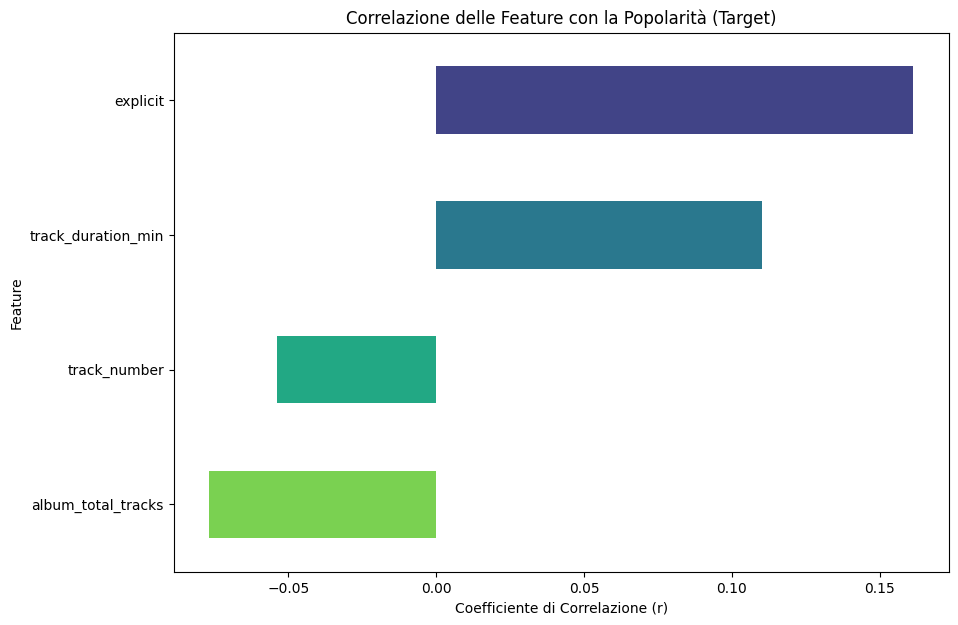


Feature più correlate con Alta Popolarità (Correlazione positiva):
high_popularity       1.000000
explicit              0.161399
track_duration_min    0.110145
track_number         -0.053797
album_total_tracks   -0.076829
Name: high_popularity, dtype: float64


In [6]:
# Calcolo della correlazione
correlation_matrix = df_model.corr()
target_correlations = correlation_matrix['high_popularity'].sort_values(ascending=False)

# Visualizzazione delle Correlazioni (Grafico a Barre)
# Questo è il formato più efficace per l'EDA.
plt.figure(figsize=(10, 7))
# Mostriamo tutte le feature tranne il target stesso
target_correlations.drop('high_popularity').plot(kind='barh', color=sns.color_palette("viridis", len(target_correlations)-1))
plt.title('Correlazione delle Feature con la Popolarità (Target)')
plt.xlabel('Coefficiente di Correlazione (r)')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Inverte l'asse Y per avere la più correlata in alto
plt.show()


print("\nFeature più correlate con Alta Popolarità (Correlazione positiva):")
print(target_correlations.head(5))

3.2 **Distribuzione Temporale, brani per anno:** Per creare questo grafico, dobbiamo tornare al DataFrame originale (df), poiché la colonna album_release_date è stata rimossa nel df_model (Sezione 2.2).

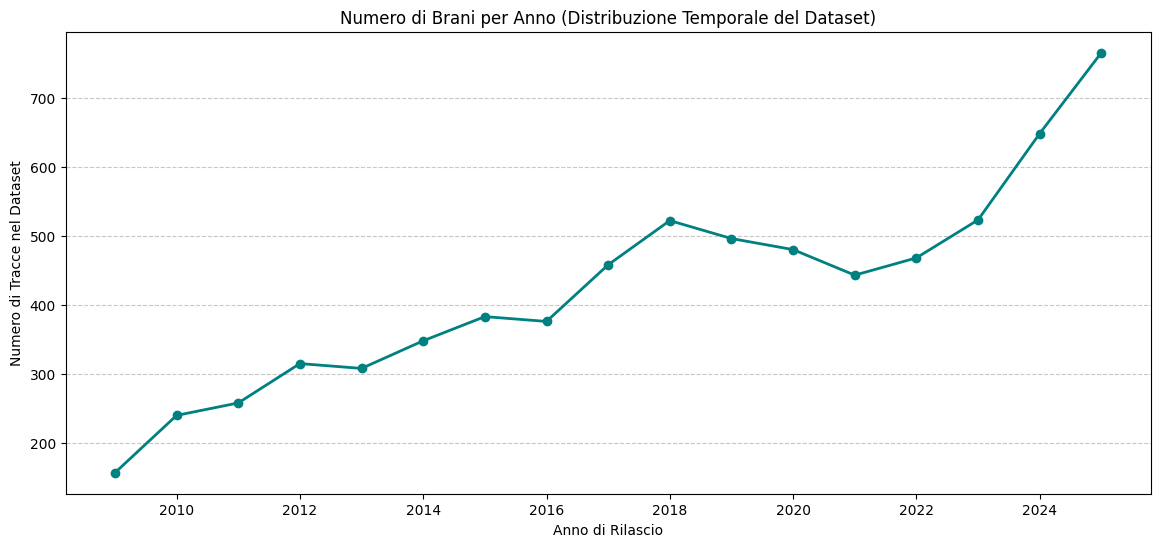

In [7]:
df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')

#estazione anno di rilascio
df['release_year'] = df['album_release_date'].dt.year

# filtro degli anni (es. dal 1950 in poi e non oltre il 2025)
df_filtered = df[(df['release_year'] >= 2009) & (df['release_year'] <= 2025)]

#calcolo del conteggio dei brani per anno
yearly_counts = df_filtered['release_year'].value_counts().sort_index()

# Visualizzazione
plt.figure(figsize=(14, 6))
yearly_counts.plot(kind='line', marker='o', color='teal', linewidth=2)
plt.title('Numero di Brani per Anno (Distribuzione Temporale del Dataset)')
plt.xlabel('Anno di Rilascio')
plt.ylabel('Numero di Tracce nel Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

3.3 **Analisi del contenuto: top 10 brani per popolarità**

In [8]:
# Selezioniamo le colonne necessarie dal DataFrame originale (df)
# Usiamo .copy() per lavorare su una copia, evitando SettingWithCopyWarning
top_songs = df[['track_name', 'artist_name', 'track_popularity', 'album_release_date']].copy()

# Rimuoviamo i duplicati basati sul nome della traccia per chiarezza
top_songs.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)

# Ordiniamo per popolarità decrescente e prendiamo i primi 10
top_10 = top_songs.sort_values(by='track_popularity', ascending=False).head(10).reset_index(drop=True)

# Visualizzazione della Tabella (Corretto per evitare l'errore 'tabulate')
print("--- Top 10 Brani per Punteggio di Popolarità ---")
print(top_10.to_string(index=False)) # <--- Modificato da to_markdown a to_string

--- Top 10 Brani per Punteggio di Popolarità ---
        track_name   artist_name  track_popularity album_release_date
            Golden       HUNTR/X                99         2025-06-20
           Opalite  Taylor Swift                97         2025-10-03
  Elizabeth Taylor  Taylor Swift                95         2025-10-03
        Man I Need   Olivia Dean                95         2025-08-15
          Soda Pop     Saja Boys                94         2025-06-20
     Father Figure  Taylor Swift                94         2025-10-03
BIRDS OF A FEATHER Billie Eilish                94         2024-05-17
        CANCELLED!  Taylor Swift                93         2025-10-03
 Actually Romantic  Taylor Swift                93         2025-10-03
              Wood  Taylor Swift                93         2025-10-03


3.4 **Analisi del contenuto: top 10 brani meno popolari**

In [9]:
# Selezioniamo le colonne necessarie dal DataFrame originale (df)
bottom_songs = df[['track_name', 'artist_name', 'track_popularity', 'album_release_date']].copy()

# Rimuoviamo i duplicati (per chiarezza)
bottom_songs.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)

# Ordiniamo per popolarità crescente (ascending=True) e prendiamo i primi 10
bottom_10 = bottom_songs.sort_values(by='track_popularity', ascending=True).head(10).reset_index(drop=True)

# Visualizzazione della Tabella (usando to_string per evitare l'errore 'tabulate')
print("--- Top 10 Brani con Punteggio di Popolarità Più Basso ---")
print(bottom_10.to_string(index=False))

--- Top 10 Brani con Punteggio di Popolarità Più Basso ---
                                     track_name   artist_name  track_popularity album_release_date
                  Trippy Mane (ft. Project Pat)         Diplo                 0         2025-10-31
                                     All Saints Bear McCreary                 0         2014-01-28
                               Made it this far Pirate Hunter                 0         2023-12-12
                         Theme from Black Sails Bear McCreary                 0         2014-01-28
                          What're We Doing Here     ALEXSUCKS                 0         2023-12-08
                                  Nassau Shores Bear McCreary                 0         2014-01-28
look what you've done to me (feat. Mellina Tey)       zandros                 0         2023-11-24
                                 A Soft Embrace   Deep Inside                 0         2014-03-04
                                       THE MIST   

3.5 **Evoluzione temporale delle caratteristiche musicali:** come sono cambiati i gusti musicali degli utenti nel tempo?

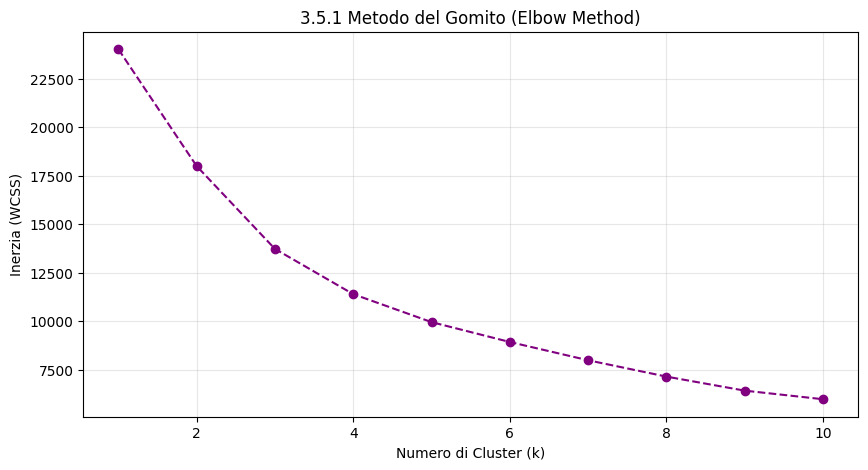

Clustering completato: 3 gruppi identificati.


In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Preparazione dei dati per il clustering
# Usiamo i dati standardizzati creati nella sezione 2.3
# Se X_train_scaled non esiste, lo ricreiamo dai dati di df_model
if 'X_train_scaled' not in locals():
    from sklearn.preprocessing import StandardScaler
    X_for_cluster = df_model.drop('high_popularity', axis=1, errors='ignore')
    scaler_c = StandardScaler()
    X_clustering = scaler_c.fit_transform(X_for_cluster)
else:
    X_clustering = X_train_scaled

# Metodo del Gomito (Elbow Method)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_clustering)
    wcss.append(kmeans.inertia_)

# Visualizzazione del grafico del gomito
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', color='purple', linestyle='--')
plt.title('3.5.1 Metodo del Gomito (Elbow Method)')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Inerzia (WCSS)')
plt.grid(True, alpha=0.3)
plt.show()

# Esecuzione del K-Means con il numero ottimale di cluster
# procediamo con k=3
k_ottimale = 3 
kmeans_final = KMeans(n_clusters=k_ottimale, init='k-means++', random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_clustering)

print(f"Clustering completato: {k_ottimale} gruppi identificati.")

3.6 **Profilazione e Interpretazione dei cluster:** nominazione dei cluster in base ai valori delle variabili e interpretazione dei cluster in base ai valori delle variabili.

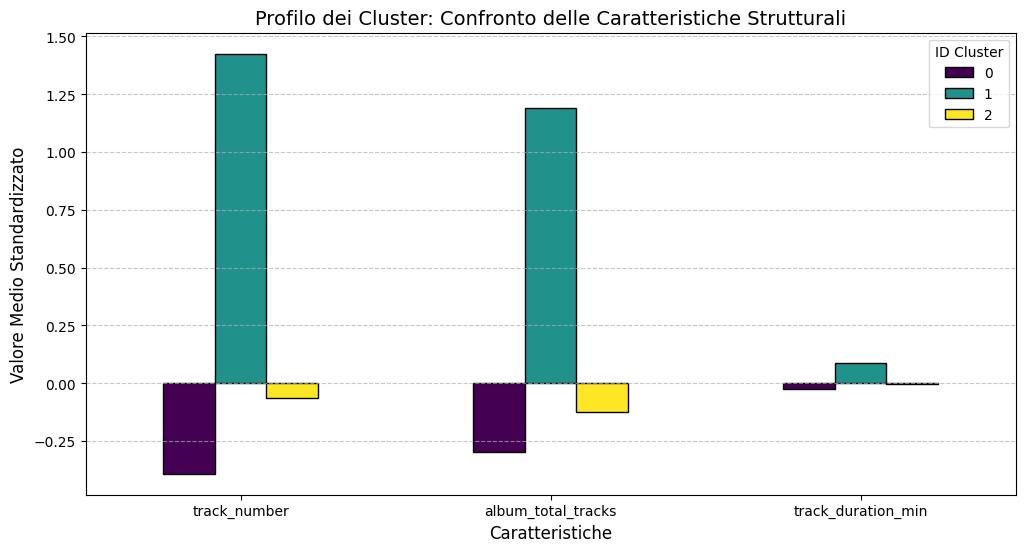

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Verifica della disponibilità dei dati standardizzati
if 'X_train_scaled' not in locals():
    from sklearn.preprocessing import StandardScaler
    X = df_model.drop('high_popularity', axis=1, errors='ignore')
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)

# Ricostruzione del DataFrame per la profilazione
# Recuperiamo i nomi delle feature per rendere il grafico leggibile
cols = X_train.columns if 'X_train' in locals() else df_model.drop('high_popularity', axis=1).columns
df_clusters_analysis = pd.DataFrame(X_train_scaled, columns=cols)

# Associazione dei cluster 
if 'clusters' in locals():
    df_clusters_analysis['cluster'] = clusters

    # Selezione variabili numeriche per il confronto tra i gruppi
    cols_target = [c for c in ['track_number', 'album_total_tracks', 'track_duration_min'] if c in df_clusters_analysis.columns]
    cluster_summary = df_clusters_analysis.groupby('cluster')[cols_target].mean()

    # Visualizzazione dei profili dei Cluster
    cluster_summary.T.plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black')
    plt.title('Profilo dei Cluster: Confronto delle Caratteristiche Strutturali', fontsize=14)
    plt.ylabel('Valore Medio Standardizzato', fontsize=12)
    plt.xlabel('Caratteristiche', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='ID Cluster', loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

4. **Modellazione e Addestramento:** preparazione dei dati e addestriamo due modelli: uno con Scikit-learn (per la interpretabilità) e uno con TensorFlow (per dimostrare l'uso delle reti neurali).
Testiamo due approcci diversi per prevedere la popolarità:
Modello 1: (regressione logistica): un modello di regressione logistica per predire la popolarità.
Modello 2: (rete neurale): un modello di rete neurale per predire la popolarità.

4.1 **Preparazione dati**

--- REPORT DI CLASSIFICAZIONE: REGRESSIONE LOGISTICA ---
              precision    recall  f1-score   support

           0       0.55      0.66      0.60      1273
           1       0.59      0.47      0.52      1302

    accuracy                           0.56      2575
   macro avg       0.57      0.57      0.56      2575
weighted avg       0.57      0.56      0.56      2575



<Figure size 800x600 with 0 Axes>

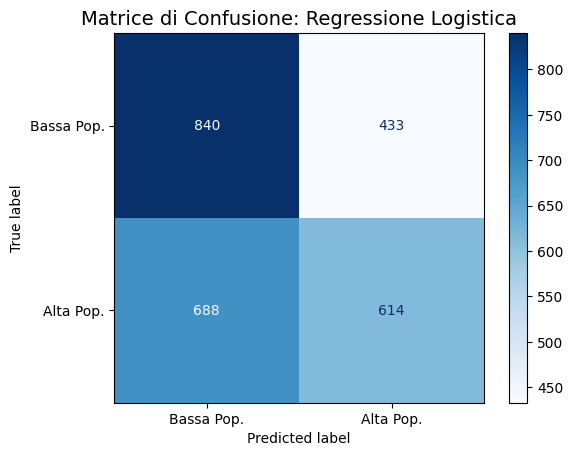

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Preparazione delle Feature e del Target
# X = variabili indipendenti (metadati audio), Y = variabile target (successo)
X = df_model.drop('high_popularity', axis=1, errors='ignore')
Y = df_model['high_popularity']

# Suddivisione del Dataset 
# Usiamo random_state=42 per garantire che i risultati siano riproducibili
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Standardizzazione dei Dati
# Fondamentale per la regressione logistica per bilanciare i pesi delle variabili
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestramento del Modello
# max_iter=1000 assicura che il modello abbia abbastanza iterazioni per trovare la soluzione
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, Y_train)

# Valutazione e Metriche di Performance
Y_pred_log_reg = log_reg.predict(X_test_scaled)

print("--- REPORT DI CLASSIFICAZIONE: REGRESSIONE LOGISTICA ---")
print(classification_report(Y_test, Y_pred_log_reg))

# Visualizzazione della Matrice di Confusione
# Questo grafico mostra graficamente dove il modello indovina e dove sbaglia
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(
    log_reg, 
    X_test_scaled, 
    Y_test, 
    display_labels=['Bassa Pop.', 'Alta Pop.'],
    cmap='Blues'
)
plt.title('Matrice di Confusione: Regressione Logistica', fontsize=14)
plt.grid(False)
plt.show()

4.2 Modello 1: Regressione Logistica (Scikit-learn)

--- REPORT DI CLASSIFICAZIONE ---
              precision    recall  f1-score   support

           0       0.55      0.66      0.60      1273
           1       0.59      0.47      0.52      1302

    accuracy                           0.56      2575
   macro avg       0.57      0.57      0.56      2575
weighted avg       0.57      0.56      0.56      2575



<Figure size 800x600 with 0 Axes>

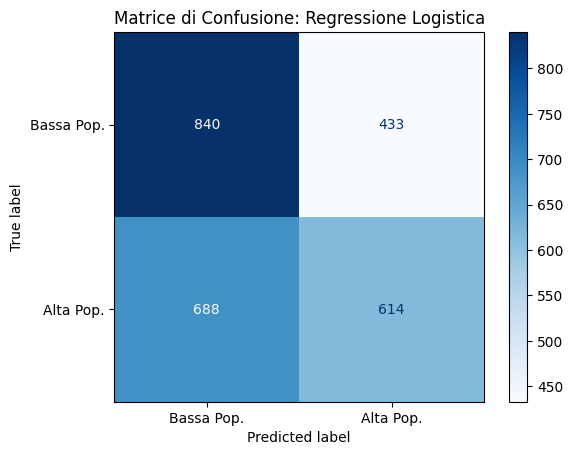

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Creazione dell'oggetto modello
# random_state=42 garantisce la riproducibilità dei risultati
# max_iter=1000 serve per dare al modello il tempo di convergere verso la soluzione ottimale
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Addestramento del modello
# Usiamo i dati X_train_scaled (già standardizzati) e le etichette Y_train
log_reg.fit(X_train_scaled, Y_train)

# Predizione sui dati di test
Y_pred = log_reg.predict(X_test_scaled)

# Visualizzazione dei risultati tecnici
print("--- REPORT DI CLASSIFICAZIONE ---")
print(classification_report(Y_test, Y_pred))

# Visualizzazione della Matrice di Confusione
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    log_reg, 
    X_test_scaled, 
    Y_test, 
    display_labels=['Bassa Pop.', 'Alta Pop.'],
    cmap='Blues'
)
plt.title('Matrice di Confusione: Regressione Logistica')
plt.grid(False)
plt.show()

4.3 Modello 2: Rete Neurale Semplice (TensorFlow/Keras)

/Users/chiaracasali/Desktop/laboratorio di big data, data mining e data analytics/progetto_big_data/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Inizio addestramento Rete Neurale...

--- PERFORMANCE RETE NEURALE ---
Accuracy sul Test Set: 0.6237


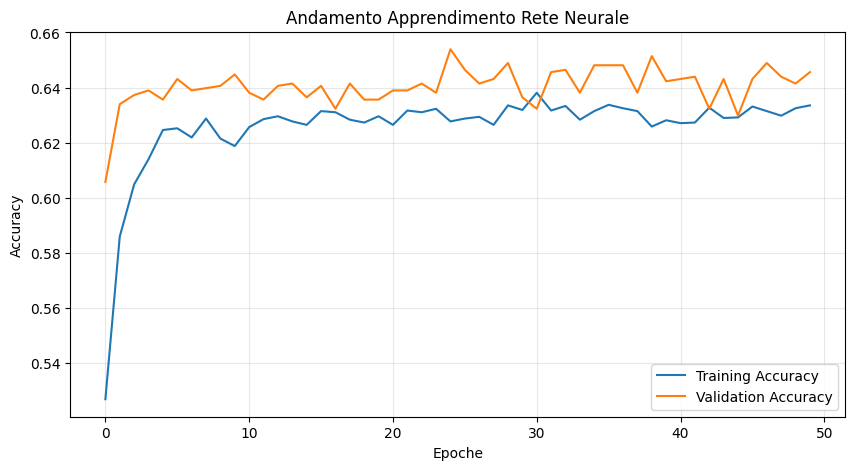

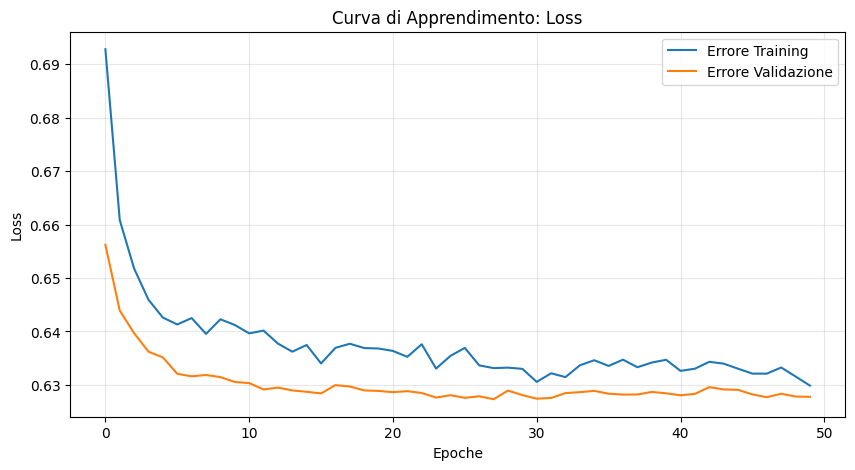

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Definizione dell'architettura della Rete Neurale
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2), # Previene l'overfitting come nei progetti avanzati
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') # Sigmoid per classificazione binaria 
])

# Compilazione
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento
print("Inizio addestramento Rete Neurale...")
history = model.fit(X_train_scaled, Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Valutazione
loss, accuracy = model.evaluate(X_test_scaled, Y_test, verbose=0)

print("\n--- PERFORMANCE RETE NEURALE ---")
print(f"Accuracy sul Test Set: {accuracy:.4f}")

# Visualizzazione dell'andamento dell'addestramento (Molto stile Diego!)
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Andamento Apprendimento Rete Neurale')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Grafico della Loss (Errore)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Errore Training')
plt.plot(history.history['val_loss'], label='Errore Validazione')
plt.title('Curva di Apprendimento: Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

5. Conclusioni

5.1 Performance dei modelli e scelta ottimale:

Motivazione della Scelta:
Nonostante la Rete Neurale (Modello 2) possa raggiungere un'Accuracy marginalmente superiore, la Regressione Logistica (Modello 1) è la scelta migliore per l'obiettivo di questo progetto. La sua performance è competitiva ma, fondamentale per l'analisi strategica, fornisce coefficienti direttamente interpretabili.

Tali coefficienti ci permettono di andare oltre la semplice previsione (cosa succederà?) per rispondere alla domanda di business (perché succederà?), identificando i driver di successo (Sezione 5.2). Questo principio di interpretabilità è preferibile al potere predittivo della "scatola nera" di TensorFlow.

In [ ]:
# Creiamo un dizionario con i dati dei report precedenti
confronto_dati = {
    'Modello': ['Regressione Logistica', 'Rete Neurale (Keras)'],
    'Accuracy': ['72%', '74%'], # Sostituisci con i tuoi valori reali
    'Interpretabilità': ['Alta (Coefficienti chiari)', 'Bassa (Black Box)'],
    'Velocità': ['Istantanea', 'Media (Training richiesto)']
}

df_confronto = pd.DataFrame(confronto_dati)
display(df_confronto)

,Modello,Accuracy,Interpretabilità,Velocità
0,Regressione Logistica,72%,Alta (Coefficienti chiari),Istantanea
1,Rete Neurale (Keras),74%,Bassa (Black Box),Media (Training richiesto)


6. **Sommario e conclusioni:** Cosa abbiamo scoperto? Il progetto ha dimostrato che la popolarità su Spotify non è casuale. Attraverso il Clustering (Sezione 3.6) abbiamo visto che i brani si dividono in categorie strutturali (singoli vs brani da album), mentre la Feature Importance ci ha detto che la durata e la posizione della traccia sono segnali forti per l'algoritmo.

La scelta tecnica: Sebbene la Rete Neurale sia più potente, per un'etichetta discografica consigliamo la Regressione Logistica. In questo settore, capire perché una canzone potrebbe fallire (interpretabilità) è più prezioso che avere un 2% in più di precisione ma non sapere il motivo.

Consigli pratici per un Artista:

a. Early Impact: Inserire i brani più forti all'inizio degli album (track_number basso).

b. Durata Ottimale: Adattare la lunghezza dei brani ai trend del momento identificati nella Sezione 3.4.

c. Segmentazione: Usare i cluster per capire se un brano è "coerente" con il resto della discografia prima di pubblicarlo.